In [ ]:
%pip install transformers datasets

In [1]:
from probs.gptb import GPTBForCausalLM, GPTBConfig
from probs.gptb import ByteTokenizer

tokenizer = ByteTokenizer()


2025-03-02 18:48:28.023896: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 18:48:28.247965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-02 18:48:28.333901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-02 18:48:28.357175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 18:48:28.509954: I tensorflow/core/platform/cpu_feature_guar

In [6]:
import torch

# Simple collation for fixed-size batches (adjust padding as needed).
def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    # Pad the sequences to the same length.
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = (input_ids != 0).long()
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": input_ids}

def tokenize_fn(example):
    tokens = tokenizer(example["text"])
    return {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"]
    }

In [7]:

from torch.utils.data import DataLoader
from datasets import Dataset

# load our custom dataset
# path : ~/code/pst/raw/2020/*.txt

import os
import glob

def load_text_files(path):
    texts = []
    for file_path in glob.glob(path):
        with open(file_path, "r") as f:
            texts.append(f.read())
    return texts

dummy_texts = load_text_files("/home/pkd/code/pst/raw/2020/*.txt")

# split into 1024 bytes sections
def split_text(text, chunk_size=512):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

dummy_texts = [split_text(text) for text in dummy_texts]
dummy_texts = [item for sublist in dummy_texts for item in sublist]




# Create a Hugging Face Dataset from the list of sentences.
dummy_dataset = Dataset.from_dict({"text": dummy_texts})

# Assume you have a tokenizer (for instance, from your GPTB model).
# tokenizer should be a callable that takes text and returns a dict with "input_ids" and "attention_mask".
def tokenize_fn(example):
    tokens = tokenizer(example["text"])
    return {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"]
    }

tokenized_dataset = dummy_dataset.map(tokenize_fn, batched=False)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

train_loader = DataLoader(tokenized_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Test to see a batch from the DataLoader.
for batch in train_loader:
    print(batch)
    break

Map:   0%|          | 0/7982 [00:00<?, ? examples/s]

{'input_ids': tensor([[ 32,  68, 101,  ...,  97, 116, 117],
        [ 32,  99, 111,  ...,   0,   0,   0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[ 32,  68, 101,  ...,  97, 116, 117],
        [ 32,  99, 111,  ...,   0,   0,   0]])}


In [ ]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer


# Load dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# Function to split text into chunks
def split_text(examples):
    chunk_size = 512  # Character-based splitting (adjust if needed)
    all_chunks = []
    for text in examples["text"]:
        # Split text into chunks
        chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
        # Filter out empty chunks
        chunks = [chunk for chunk in chunks if chunk.strip()]
        all_chunks.extend(chunks)
    return {"text": all_chunks}

# Apply splitting to each dataset split using batched processing for efficiency
dataset = dataset.map(split_text, batched=True, batch_size=1000)

# Tokenization function


# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_fn, batched=True)

# Set dataset format to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])


# Create DataLoader for the training split
train_loader = DataLoader(
    tokenized_dataset["train"],
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

# Test a batch
for batch in train_loader:
    print(batch)
    break

In [3]:
# write some code to test cuda
import torch

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# do basic tensor operations
x = torch.tensor([1, 2, 3], device=device)
y = torch.tensor([4, 5, 6], device=device)

z = x + y
print(z)

c = torch.matmul(x, y)
print(c)

config = GPTBConfig()


tensor([5, 7, 9])
tensor(32)


In [ ]:
import os

os.environ["AMD_SERIALIZE_KERNEL"] = "3"

import torch
from tqdm.auto import tqdm


print(device)

# Verify vocabulary size matches tokenizer
print(f"Model vocab size: {config.vocab_size}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")  # Add your tokenizer reference

model = GPTBForCausalLM(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

epochs = 3

for epoch in range(epochs):
    print(f"\nEpoch: {epoch+1}")
    model.train()
    epoch_loss = 0.0
    progress = tqdm(train_loader, desc="Training")
    for batch in progress:
        optimizer.zero_grad()

        # Move batch to device with validation
        batch = {k: v.to(device) for k, v in batch.items()}

        # Debug: Check input/label ranges
        #print("Input IDs range:", batch["input_ids"].min(), batch["input_ids"].max())
        #if "labels" in batch:
        #    print("Labels range:", batch["labels"].min(), batch["labels"].max())

        # Add labels for causal LM
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["input_ids"]  # Auto-regressive LM uses input_ids as labels
        )

        # Debug: Check loss value
        loss = outputs.loss
        #print("Loss value:", loss.item())

        # Check for NaN/inf
        if torch.isnan(loss).any() or torch.isinf(loss).any():
            raise ValueError("NaN/Inf detected in loss")

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Loss:", epoch_loss / len(train_loader))

model.save_pretrained("gptb-model")

cpu
Model vocab size: 256
Tokenizer vocab size: 256

Epoch: 1


Training:   0%|          | 0/3991 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
model.save_pretrained("gptb-model")

In [ ]:
import torch
import torch.nn.functional as F

# Load the model
model = GPTBForCausalLM.from_pretrained("gptb-model").to(device)

model.eval()
# tokenize the initial input sentence
input_ids = tokenizer("This is a test sentence.")["input_ids"]
input_ids = torch.tensor(input_ids).unsqueeze(0)

probs = []

# generate probailities distributions for all tokens in the input sentence
for i in range(len(input_ids[0])):
    outputs = model(input_ids=input_ids)
    next_token_logits = outputs.logits[0, -1, :]
    next_token_probs = F.softmax(next_token_logits, dim=-1)
    print("Token:", tokenizer.decode([input_ids[0][i].item()]), "Probs:", next_token_probs)
    probs.append(next_token_probs)

# analysie entropy and perplexity
total_entropy = 0.0
total_perplexity = 0.0
for prob in probs:
    entropy = -torch.sum(prob * torch.log2(prob))
    perplexity = 2 ** entropy
    total_entropy += entropy
    total_perplexity += perplexity

print("Total Entropy:", total_entropy.item())
print("Total Perplexity:", total_perplexity.item())


You are using a model of type gptb to instantiate a model of type gpt2. This is not supported for all configurations of models and can yield errors.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gptb-model and are newly initialized: ['h.0.attn.c_attn.bias', 'h.0.attn.c_attn.weight', 'h.0.attn.c_proj.bias', 'h.0.attn.c_proj.weight', 'h.0.ln_1.bias', 'h.0.ln_1.weight', 'h.0.ln_2.bias', 'h.0.ln_2.weight', 'h.0.mlp.c_fc.bias', 'h.0.mlp.c_fc.weight', 'h.0.mlp.c_proj.bias', 'h.0.mlp.c_proj.weight', 'h.1.attn.c_attn.bias', 'h.1.attn.c_attn.weight', 'h.1.attn.c_proj.bias', 'h.1.attn.c_proj.weight', 'h.1.ln_1.bias', 'h.1.ln_1.weight', 'h.1.ln_2.bias', 'h.1.ln_2.weight', 'h.1.mlp.c_fc.bias', 'h.1.mlp.c_fc.weight', 'h.1.mlp.c_proj.bias', 'h.1.mlp.c_proj.weight', 'h.10.attn.c_attn.bias', 'h.10.attn.c_attn.weight', 'h.10.attn.c_proj.bias', 'h.10.attn.c_proj.weight', 'h.10.ln_1.bias', 'h.10.ln_1.weight', 'h.10.ln_2.bias', 'h.10.ln_2.weight', 'h.10.mlp.c_fc.bias', 

Token: T Probs: tensor([0.0041, 0.0025, 0.0059, 0.0033, 0.0030, 0.0042, 0.0097, 0.0096, 0.0014,
        0.0023, 0.0029, 0.0014, 0.0023, 0.0055, 0.0056, 0.0015, 0.0021, 0.0025,
        0.0017, 0.0031, 0.0041, 0.0019, 0.0037, 0.0033, 0.0061, 0.0059, 0.0054,
        0.0018, 0.0031, 0.0056, 0.0021, 0.0018, 0.0017, 0.0040, 0.0046, 0.0013,
        0.0006, 0.0010, 0.0045, 0.0033, 0.0029, 0.0020, 0.0049, 0.0029, 0.0035,
        0.0025, 0.0091, 0.0023, 0.0059, 0.0031, 0.0054, 0.0100, 0.0094, 0.0066,
        0.0026, 0.0034, 0.0019, 0.0026, 0.0080, 0.0028, 0.0030, 0.0061, 0.0072,
        0.0019, 0.0108, 0.0033, 0.0079, 0.0018, 0.0042, 0.0050, 0.0027, 0.0043,
        0.0051, 0.0060, 0.0032, 0.0034, 0.0033, 0.0013, 0.0036, 0.0031, 0.0033,
        0.0029, 0.0013, 0.0088, 0.0017, 0.0191, 0.0040, 0.0054, 0.0072, 0.0040,
        0.0074, 0.0035, 0.0040, 0.0008, 0.0009, 0.0097, 0.0015, 0.0014, 0.0046,
        0.0019, 0.0051, 0.0026, 0.0010, 0.0009, 0.0077, 0.0040, 0.0048, 0.0037,
        0.0018, 0.0024, 

In [5]:
import numpy as np

bad_model = GPTBForCausalLM(GPTBConfig()).to(device)

def bad_distribution(text):

    if len(text) == 0:
        # return uniform distribution
        return {i: 1/config.vocab_size for i in range(config.vocab_size)}

    tokens = tokenizer(text)["input_ids"]
    input_tensor = torch.tensor(tokens,requires_grad=False).to(device).unsqueeze(0)  
    byte_probs = bad_model(input_ids=input_tensor)
    normalized_probs = F.softmax(byte_probs.logits[0, -1, :], dim=-1).detach().cpu().numpy()
    return {i: p for i, p in enumerate(normalized_probs) if p > 0}

def good_distribution(text):

    if len(text) == 0:
        # return uniform distribution
        return {i: 1/config.vocab_size for i in range(config.vocab_size)}

    tokens = tokenizer(text)["input_ids"]
    input_tensor = torch.tensor(tokens,requires_grad=False).to(device).unsqueeze(0)
    byte_probs = model(input_ids=input_tensor)
    normalized_probs = F.softmax(byte_probs.logits[0, -1, :], dim=-1).detach().cpu().numpy()
    return {i: p for i, p in enumerate(normalized_probs) if p > 0}

# some tests
text = "This is a test sentence."
# Using the full text or a slice as needed.
bad_probs = bad_distribution(text)
good_probs = good_distribution(text)

print(bad_probs)
print(good_probs)


    

{0: 0.011013644, 1: 0.0025944, 2: 0.0033363053, 3: 0.0035171662, 4: 0.0035655224, 5: 0.0022768506, 6: 0.0037674436, 7: 0.009251117, 8: 0.0024543223, 9: 0.010656879, 10: 0.0031039836, 11: 0.0034548938, 12: 0.00047433845, 13: 0.004253639, 14: 0.012505285, 15: 0.0039083264, 16: 0.0030187352, 17: 0.003021759, 18: 0.0033807533, 19: 0.0012349467, 20: 0.003021883, 21: 0.0018043083, 22: 0.007610192, 23: 0.0033810951, 24: 0.006053163, 25: 0.009070532, 26: 0.007572553, 27: 0.0034522626, 28: 0.0020359387, 29: 0.0028487225, 30: 0.0015363445, 31: 0.0020783395, 32: 0.0037739507, 33: 0.0043269633, 34: 0.002160155, 35: 0.0065889647, 36: 0.010516919, 37: 0.0016263745, 38: 0.0064720367, 39: 0.0035735224, 40: 0.0011878468, 41: 0.0032673457, 42: 0.0031408211, 43: 0.0034326972, 44: 0.0056500435, 45: 0.0014628792, 46: 0.0076604425, 47: 0.0031059834, 48: 0.0033397868, 49: 0.0015124042, 50: 0.002217001, 51: 0.009783718, 52: 0.002815719, 53: 0.0044258735, 54: 0.003975587, 55: 0.004946972, 56: 0.0023570291, 57:

Starting with: 'I looking at cats sitting on mats.'
Analyzing generation of: 'I looking at cats sitting on mats.'
--------------------------------------------------

Position 1: Generating 'I'
Entropy at this position: 8.0000 bits
Probability of 'I': 0.003906
Surprise value: 8.0000 bits
Top 5 predicted bytes:
  \x00: 0.003906
  \x01: 0.003906
  \x02: 0.003906
  \x03: 0.003906
  \x04: 0.003906

Position 2: Generating ' '
Entropy at this position: 7.7357 bits
Probability of ' ': 0.001542
Surprise value: 9.3408 bits
Top 5 predicted bytes:
  I: 0.025946
  8: 0.017385
  \xf8: 0.016477
  y: 0.013136
  \xaf: 0.011333

Position 3: Generating 'l'
Entropy at this position: 7.7592 bits
Probability of 'l': 0.003578
Surprise value: 8.1266 bits
Top 5 predicted bytes:
  >: 0.013562
  x: 0.013076
  8: 0.011917
  \xdb: 0.011454
  \xaf: 0.011118

Position 4: Generating 'o'
Entropy at this position: 7.7435 bits
Probability of 'o': 0.001872
Surprise value: 9.0613 bits
Top 5 predicted bytes:
  >: 0.015213


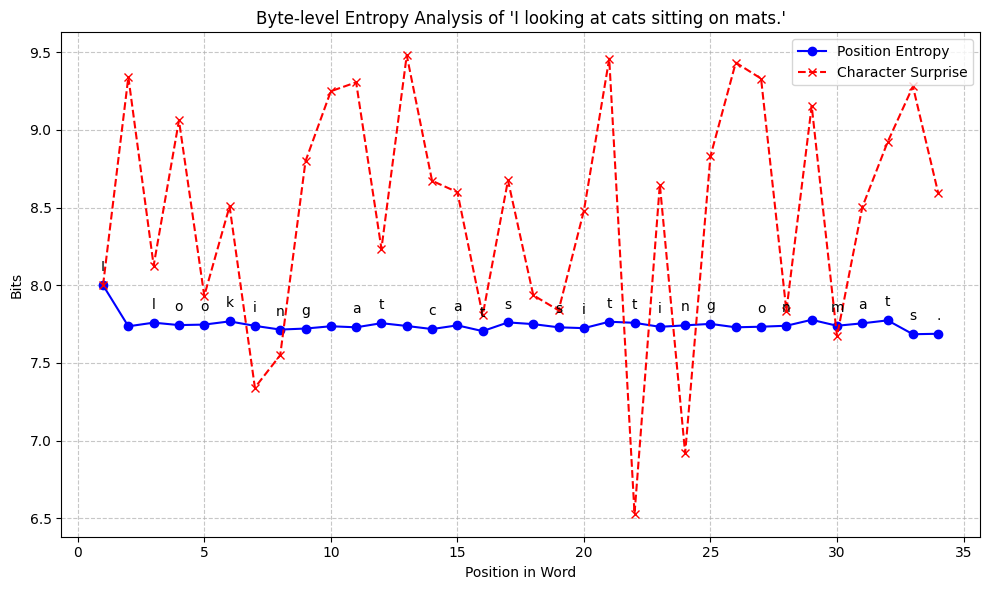

Starting with: 'I looking at cats sitting on mats.'
Analyzing generation of: 'I looking at cats sitting on mats.'
--------------------------------------------------

Position 1: Generating 'I'
Entropy at this position: 8.0000 bits
Probability of 'I': 0.003906
Surprise value: 8.0000 bits
Top 5 predicted bytes:
  \x00: 0.003906
  \x01: 0.003906
  \x02: 0.003906
  \x03: 0.003906
  \x04: 0.003906

Position 2: Generating ' '
Entropy at this position: 7.7864 bits
Probability of ' ': 0.001735
Surprise value: 9.1706 bits
Top 5 predicted bytes:
  d: 0.014246
  \xb2: 0.012153
  \x91: 0.012024
  \xa7: 0.010676
  \xce: 0.010468

Position 3: Generating 'l'
Entropy at this position: 7.7956 bits
Probability of 'l': 0.002259
Surprise value: 8.7900 bits
Top 5 predicted bytes:
  \xa9: 0.015782
  \x1e: 0.011260
  \xef: 0.011248
  \xeb: 0.011097
  $: 0.010352

Position 4: Generating 'o'
Entropy at this position: 7.7855 bits
Probability of 'o': 0.001894
Surprise value: 9.0440 bits
Top 5 predicted bytes:
  

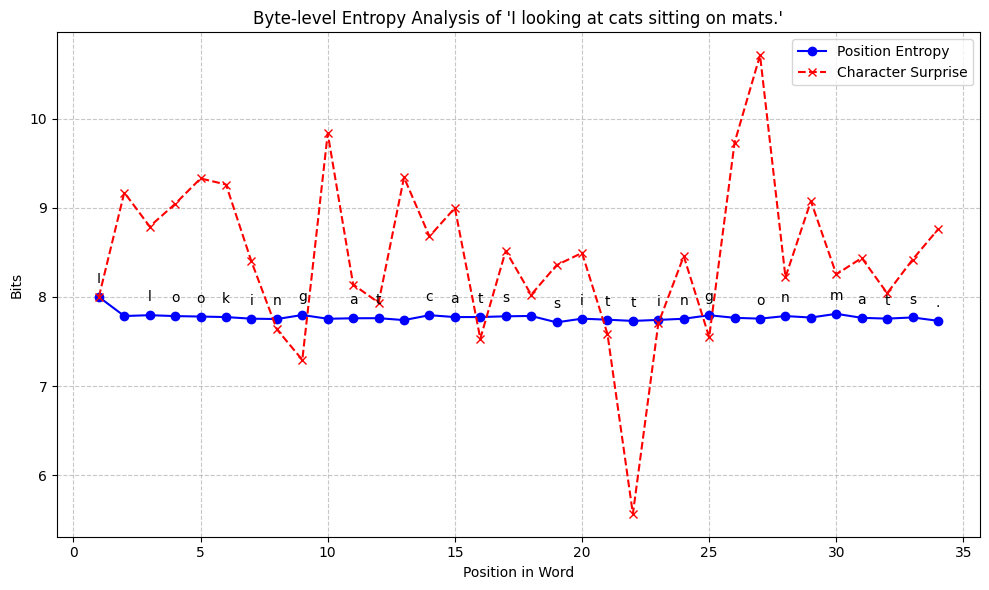

In [6]:
from probs.analysis import autoregressive_byte_analysis

text = "I looking at cats sitting on mats."

good_results = autoregressive_byte_analysis(good_distribution,text)
bad_results = autoregressive_byte_analysis(bad_distribution,text)

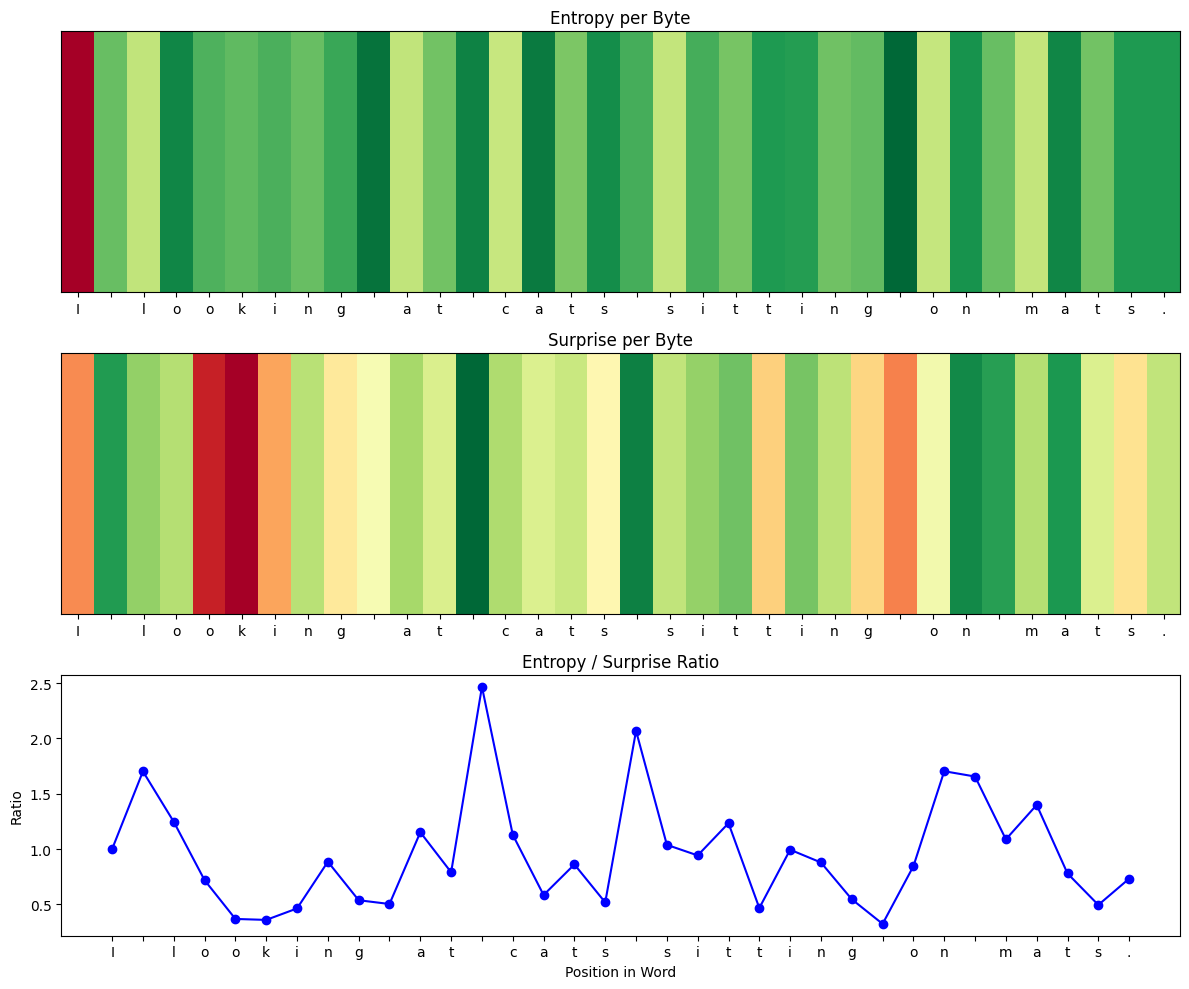

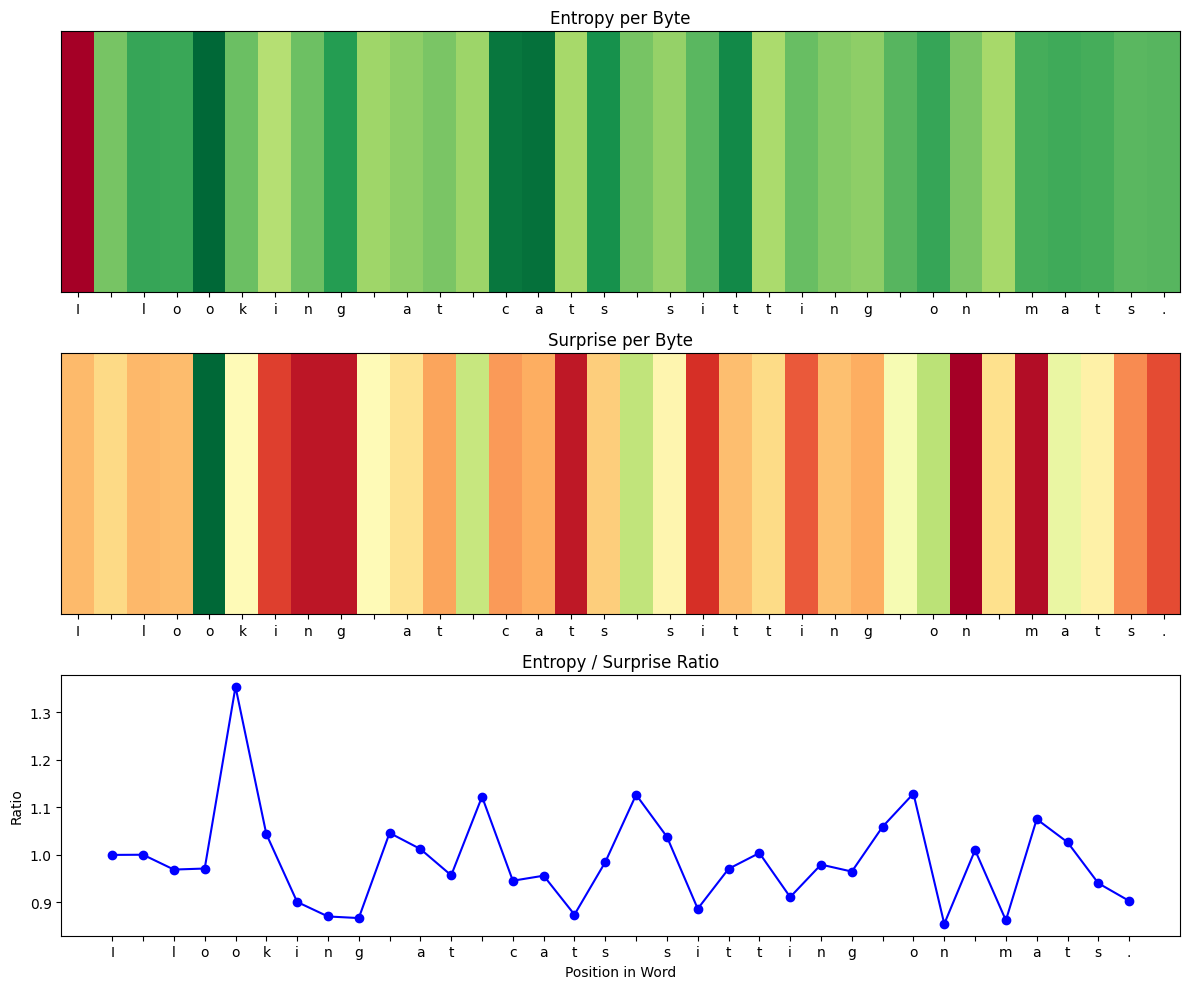

In [35]:
from probs.analysis import sentence_information_visualization

sentence_information_visualization(text, good_results)

sentence_information_visualization(text, bad_results)

In [7]:
# try some completion with our model

to_complete = "Je suis"


input_ids = tokenizer(to_complete)["input_ids"]
input_ids = torch.tensor(input_ids).unsqueeze(0)
outputs = model.generate(input_ids, max_length=100, do_sample=True, temperature=0.7)
completion = tokenizer.decode(outputs[0])
print(completion)


bad_outputs = bad_model.generate(input_ids, max_length=100, do_sample=True, temperature=0.7)
bad_completion = tokenizer.decode(bad_outputs[0])
print(bad_completion)





Je suisx�N���)ų����-U��y\
x��\�ۿ"!E_�UyXW����FF���SS�#X�=�_�Z\��dX����NS���y@Sy���X\ĉ33��ð
Je suis,WW�U��$$;2{L5A�$4�	��d�D��		33 ��!%.!�������~$U��|		�XXk�2���cv�� ���;�ݴ��0:Y�.k
